In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization
)
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory

2026-02-04 15:58:33.392810: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770220713.584411      23 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770220713.645192      23 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770220714.127531      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770220714.127567      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770220714.127570      23 computation_placer.cc:177] computation placer alr

In [2]:
!ls /kaggle/input


aslamerican-sign-language-aplhabet-dataset


In [3]:
!ls /kaggle/input/aslamerican-sign-language-aplhabet-dataset


ASL_Alphabet_Dataset


In [4]:
!ls /kaggle/input/aslamerican-sign-language-aplhabet-dataset/ASL_Alphabet_Dataset


asl_alphabet_test  asl_alphabet_train


In [5]:
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices("GPU"))


TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [6]:
IMG_SIZE = 64
BATCH_SIZE = 32
EPOCHS = 30
SEED = 123
NUM_CLASSES = 29
K_FOLDS=5

In [7]:
DATA_DIR = "/kaggle/input/aslamerican-sign-language-aplhabet-dataset/ASL_Alphabet_Dataset/asl_alphabet_train"


In [8]:
print("="*60)
print("LOADING DATA FOR ORIGINAL MODEL TRAINING")
print("="*60)

# Load data using your original method
train_data = image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

test_data = image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

print("Number of classes:", len(train_data.class_names))
print("Classes:", train_data.class_names)
print("Train batches:", train_data.cardinality().numpy())
print("Validation batches:", test_data.cardinality().numpy())

# Store class names for later
class_names = train_data.class_names

# Normalize
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_data = train_data.map(lambda x, y: (normalization_layer(x), y))
test_data = test_data.map(lambda x, y: (normalization_layer(x), y))

# Optimize performance
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

LOADING DATA FOR ORIGINAL MODEL TRAINING
Found 223074 files belonging to 29 classes.
Using 178460 files for training.


I0000 00:00:1770220838.119449      23 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1770220838.125621      23 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 223074 files belonging to 29 classes.
Using 44614 files for validation.
Number of classes: 29
Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
Train batches: 5577
Validation batches: 1395


In [9]:
print("\n" + "="*60)
print("TRAINING ORIGINAL MODEL (80-20 SPLIT)")
print("="*60 + "\n")

# Create model
model = Sequential([
    # Block 1
    Conv2D(
        16, (3,3),
        padding="same",
        activation="relu",
        kernel_regularizer=regularizers.l2(0.001),
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    ),
    BatchNormalization(),
    MaxPooling2D(2),
    Dropout(0.2),
    
    # Block 2
    Conv2D(
        32, (3,3),
        padding="same",
        activation="relu",
        kernel_regularizer=regularizers.l2(0.001)
    ),
    BatchNormalization(),
    MaxPooling2D(2),
    Dropout(0.25),
    
    # Block 3
    Conv2D(
        64, (3,3),
        padding="same",
        activation="relu",
        kernel_regularizer=regularizers.l2(0.001)
    ),
    BatchNormalization(),
    MaxPooling2D(2),
    Dropout(0.3),
    
    # Classifier
    Flatten(),
    Dense(
        128,
        activation="relu",
        kernel_regularizer=regularizers.l2(0.001)
    ),
    BatchNormalization(),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation="softmax")
])

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Callbacks
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

# Model summary
model.summary()

# Train
history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=test_data,
    callbacks=[early_stop]
)

# Save model
model.save("/kaggle/working/asl_model_original.keras")
print("\nOriginal model saved as: asl_model_original.keras")


TRAINING ORIGINAL MODEL (80-20 SPLIT)



/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 552,701 (2.11 MB)

 Trainable params: 552,221 (2.11 MB)

 Non-trainable params: 480 (1.88 KB)

Epoch 1/30


I0000 00:00:1770220910.772085      76 service.cc:152] XLA service 0x7891980071b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1770220910.772121      76 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1770220910.772124      76 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1770220911.436437      76 cuda_dnn.cc:529] Loaded cuDNN version 91002


  15/5577 ━━━━━━━━━━━━━━━━━━━━ 1:08 12ms/step - accuracy: 0.0360 - loss: 4.8409

I0000 00:00:1770220917.615238      76 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5577/5577 ━━━━━━━━━━━━━━━━━━━━ 293s 45ms/step - accuracy: 0.1619 - loss: 3.6252 - val_accuracy: 0.5856 - val_loss: 1.7621
Epoch 2/30
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - accuracy: 0.5043 - loss: 1.9270 - val_accuracy: 0.7781 - val_loss: 1.0658
Epoch 3/30
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - accuracy: 0.6755 - loss: 1.3244 - val_accuracy: 0.8658 - val_loss: 0.7262
Epoch 4/30
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - accuracy: 0.7609 - loss: 1.0154 - val_accuracy: 0.9284 - val_loss: 0.5027
Epoch 5/30
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - accuracy: 0.8084 - loss: 0.8402 - val_accuracy: 0.9377 - val_loss: 0.4359
Epoch 6/30
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - accuracy: 0.8370 - loss: 0.7260 - val_accuracy: 0.9480 - val_loss: 0.3863
Epoch 7/30
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - accuracy: 0.8550 - loss: 0.6580 - val_accuracy: 0.9660 - val_loss: 0.3260
Epoch 8/30
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - accuracy: 0.8728 - loss: 0.5978 - v

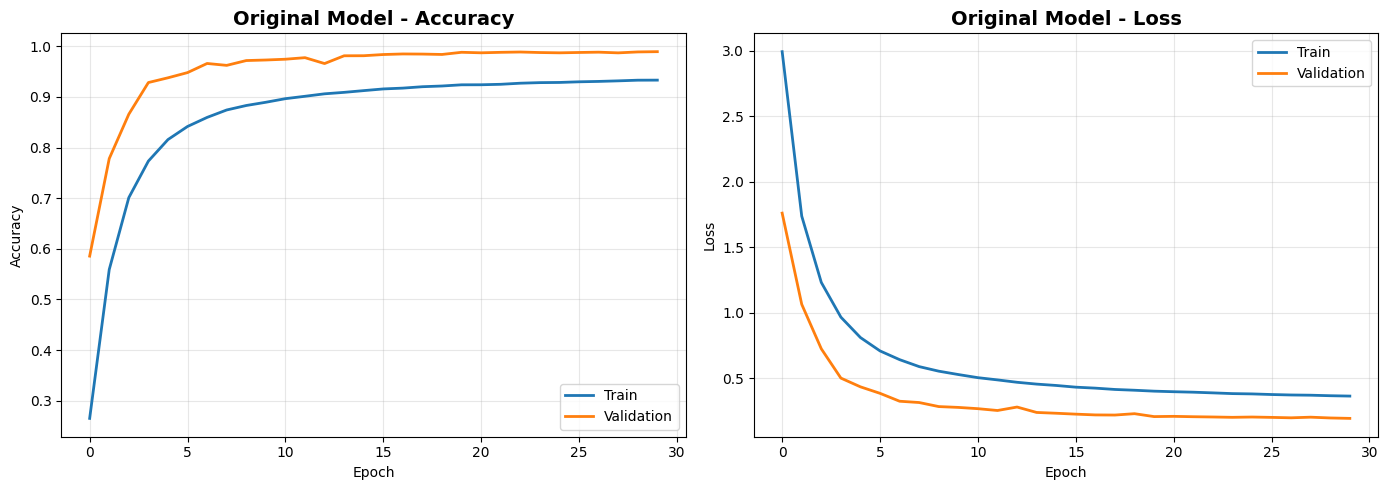


Original Model Final Metrics:
Training Accuracy: 0.9331 (93.31%)
Validation Accuracy: 0.9893 (98.93%)
Training Loss: 0.3654
Validation Loss: 0.1950


In [10]:
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train", linewidth=2)
plt.plot(history.history["val_accuracy"], label="Validation", linewidth=2)
plt.title("Original Model - Accuracy", fontweight='bold', fontsize=14)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train", linewidth=2)
plt.plot(history.history["val_loss"], label="Validation", linewidth=2)
plt.title("Original Model - Loss", fontweight='bold', fontsize=14)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/kaggle/working/original_model_history.png', dpi=300, bbox_inches='tight')
plt.show()

# final metrics
final_train_acc = history.history["accuracy"][-1]
final_val_acc = history.history["val_accuracy"][-1]
final_train_loss = history.history["loss"][-1]
final_val_loss = history.history["val_loss"][-1]

print(f"\nOriginal Model Final Metrics:")
print(f"Training Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
print(f"Training Loss: {final_train_loss:.4f}")
print(f"Validation Loss: {final_val_loss:.4f}")

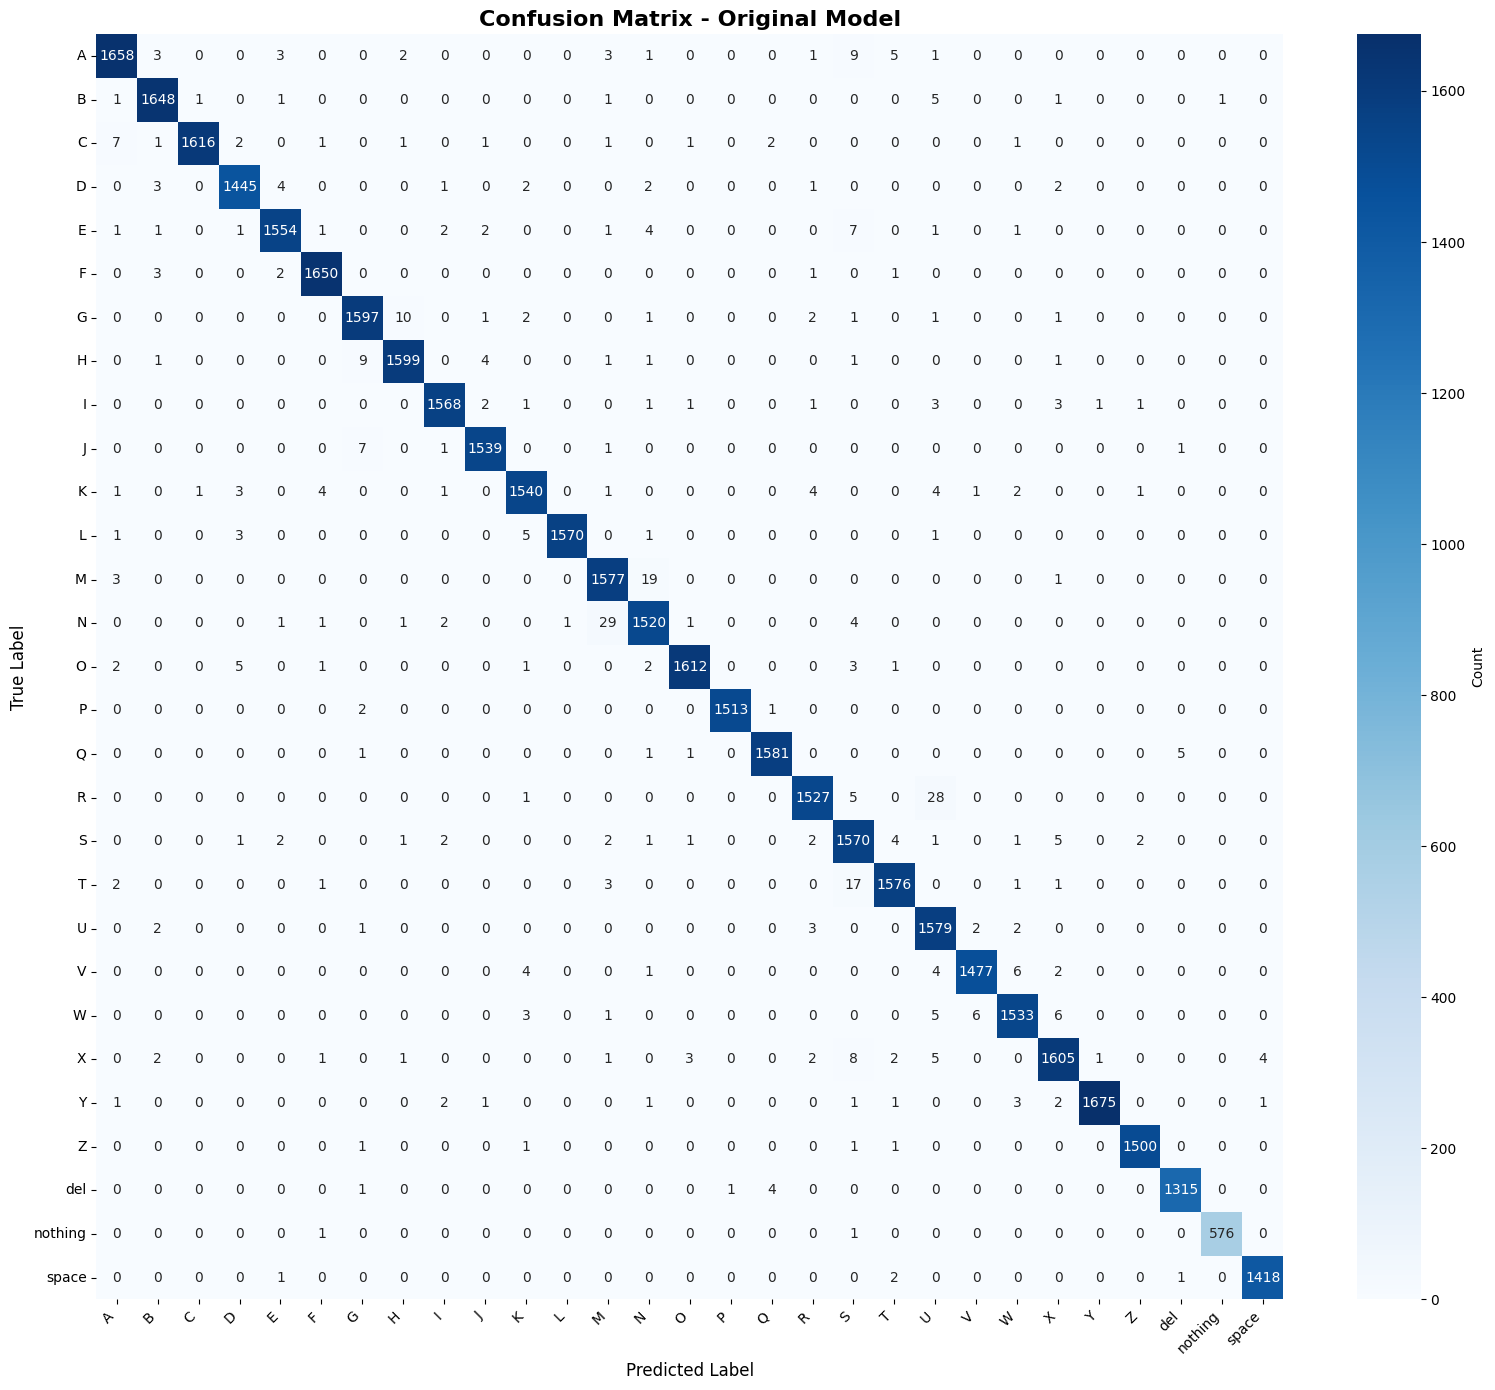


Classification Report - Original Model:
              precision    recall  f1-score   support

           A       0.99      0.98      0.99      1686
           B       0.99      0.99      0.99      1659
           C       1.00      0.99      0.99      1634
           D       0.99      0.99      0.99      1460
           E       0.99      0.99      0.99      1576
           F       0.99      1.00      0.99      1657
           G       0.99      0.99      0.99      1616
           H       0.99      0.99      0.99      1617
           I       0.99      0.99      0.99      1582
           J       0.99      0.99      0.99      1549
           K       0.99      0.99      0.99      1563
           L       1.00      0.99      1.00      1581
           M       0.97      0.99      0.98      1600
           N       0.98      0.97      0.98      1560
           O       1.00      0.99      0.99      1627
           P       1.00      1.00      1.00      1516
           Q       1.00      0.99      1

In [11]:
# Get predictions for confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
y_true = []
y_pred = []

for images, labels in test_data:
    predictions = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Original Model', fontweight='bold', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('/kaggle/working/original_model_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Classification Report
print("\nClassification Report - Original Model:")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_names))

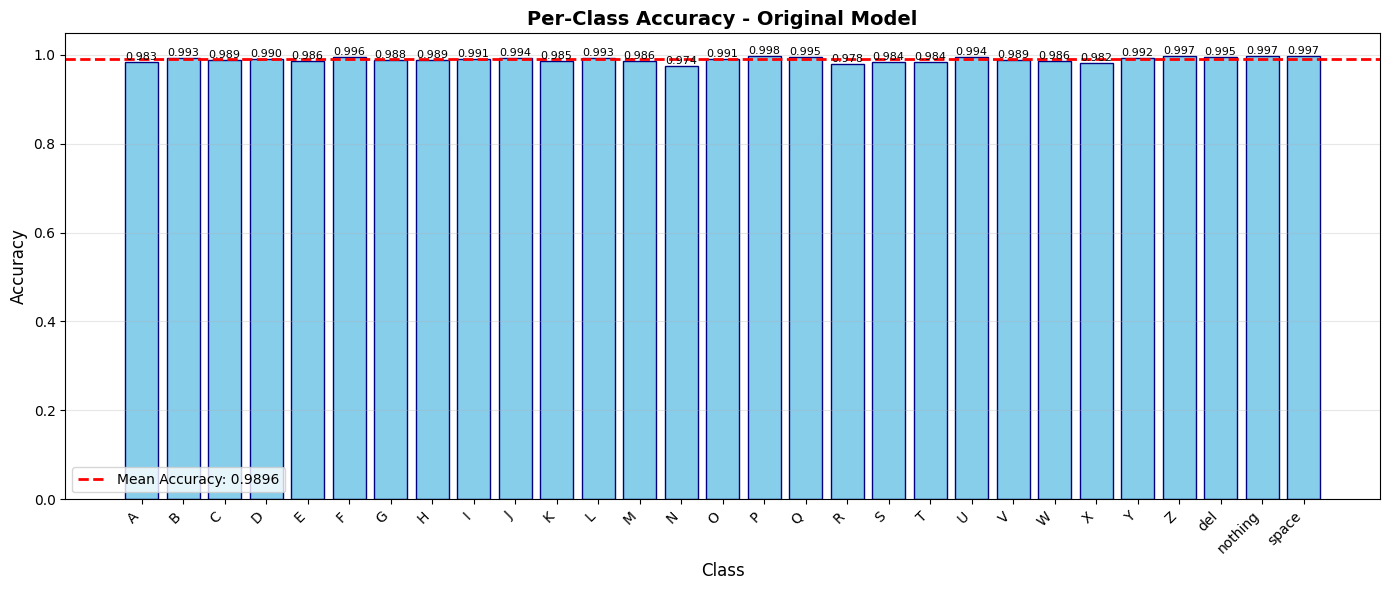

In [12]:
# Calculate per-class accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)

plt.figure(figsize=(14, 6))
bars = plt.bar(class_names, class_accuracy, color='skyblue', edgecolor='navy')
plt.axhline(np.mean(class_accuracy), color='red', linestyle='--', linewidth=2, 
            label=f'Mean Accuracy: {np.mean(class_accuracy):.4f}')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Per-Class Accuracy - Original Model', fontweight='bold', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, acc in zip(bars, class_accuracy):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('/kaggle/working/original_model_class_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
 # fold_accuracies.append(val_accuracy)
 #    fold_losses.append(val_loss)
 #    fold_histories.append(history.history)
    
 #    print(f"\n{'='*60}")
 #    print(f"Fold {fold + 1} Results:")
 #    print(f"{'='*60}")
 #    print(f"Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
 #    print(f"Validation Loss: {val_loss:.4f}")
    